# Trabalho 1 - PCA e KNN.         Nícolas Hecker Silva         RA: 186132

A primeira parte importante desse trabalho é baixar as dependencias necessárias usando pip, caso a máquina não as possua. Para isso usamos o código abaixo:

In [5]:
# instalar dependencias
!pip install pandas
!pip install jax
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install scikit-learn
!pip install matplotlib


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Agora podemos prosseguir para a primeira etapa.

# Obtendo os dados

Os dados utilizados nessa tarefa são do dataset de vinhos nativos do scikit learn datasets, por ser um dataset comumente utilizado para tentativas iniciais de algoritmos de aprendizado de máquina.
Vamos carregar e análisar como ele é

In [6]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

print(np.unique(data["target"]))

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

Podemos ver que o dataset contém 178 amostras, cada uma com 14 características (features), usadas para reconhecer uma amostra de vinho.

As features presentes no dataset são:

- alcohol: Teor alcoólico do vinho.
- malic_acid: Conteúdo de ácido málico no vinho.
- ash: Conteúdo total de cinzas no vinho.
- alcalinity_of_ash: Alcalinidade das cinzas no vinho.
- magnesium: Conteúdo de magnésio no vinho.
- total_phenols: Conteúdo total de fenóis no vinho.
- flavanoids: Conteúdo de flavanóides no vinho.
- nonflavanoid_phenols: Conteúdo de não flavanóides no vinho.
- proanthocyanins: Conteúdo de proantocianidinas no vinho.
- color_intensity: Intensidade de cor do vinho.
- hue: Matiz do vinho.
- od280/od315_of_diluted_wines: Razão da densidade óptica a 280 nm para a densidade óptica a 315 nm de vinhos diluídos.
- proline: Conteúdo de prolina no vinho.

As classes desse dataset são 0, 1 e 2, e significam os locais onde esses vinhos foram feitos

Cada feature possui uma dimensão específica, variando mais ou menos que as outras, uma vez que possuem signficados diferentes. Plotar elas em um gráfico bidimensional seria interessante para poder visuzalizar bem como esses dados se comportam. Vamos tentar plotar as duas primeiras features para ver se existe alguma separação



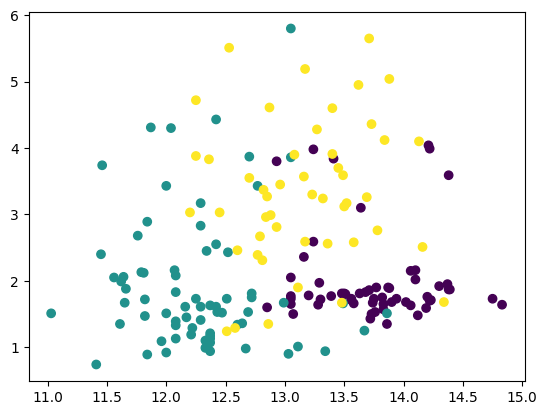

In [31]:
plt.scatter(data["alcohol"], data["malic_acid"], c=data["target"])
plt.show()
plt.close()

No quadro acima plotamos o álcool no eixo x e o ácido málico no eixo y. Suas unidades são distintas, mas a ferramenta matplotlib cuida de organizar a imagem de forma aceitável. Há grupos (aglomerados) visíveis no plot, mas ainda assim há muitos pontos de confusão, como o centro entre os três aglomerados. Nesse lugar não é possível classificar os pontos apenas pelas suas dua features. Mais ainda, há um ponto ao topo, no aglomerado amarelo, que é da classe azul, o que mostra que a sua classe seria classificada como amarelo, se fosse utilizado apenas essas duas features para classificar os pontos, muitos pontos seriam confundidos.

Vamos escolher outras duas features aleatoriamente.

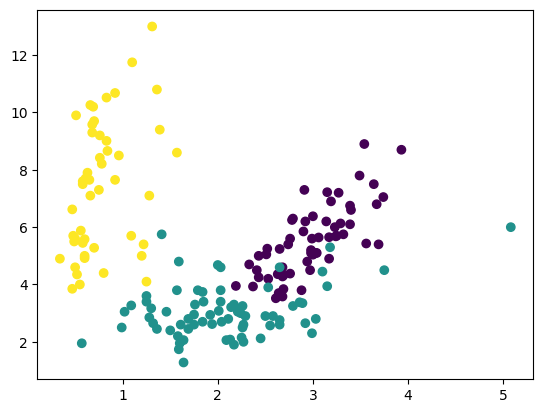

In [27]:
plt.scatter(data["flavanoids"], data["color_intensity"], c=data["target"])
plt.show()
plt.close()

Usando o flavonoids e a intensidade de cor, podemos ver uma divisão mais clara entre as classes, sendo facilmente separados os pontos atraves de seus aglomerados. Entretanto há uma pequena região em que os pontos roxos e azuis se mesclam, além de pontos azuis na parte direita da imagem que deveriam ser classificados como roxos. Esses pontos mesclados, poderiam estar entre os pontos separados das features anteriores, assim como em outras features relevantes. Vamos analisar o que ocorre com outras 3 features. Para isso será necessário adicionar o tamanho como um terceiro eixo.

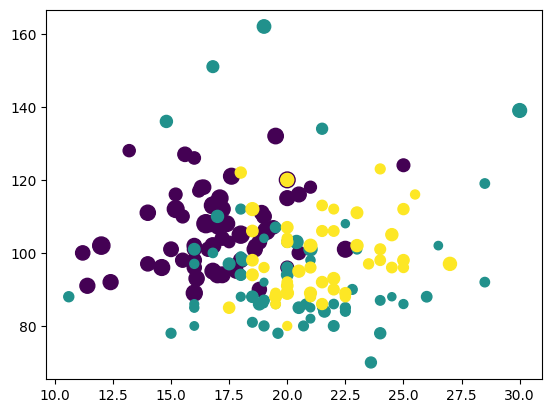

In [44]:
plt.scatter(data["alcalinity_of_ash"], data["magnesium"], s=data["proline"]//10, c=data["target"])
plt.show()
plt.close()

Aqui podemos ver que essas tres features não são facilmente separáveis. A dimensão do tamanho foi útil para diferenciar algumas amostras que tinha a mesma dimensão x,y, mas há alguns problemas: A ordem das asmotras pode impossibilitar que vejamos pontos peqenos atrás de pontos grandes. Não é muito fácil ver a divisão que ocorre no eixo do tamanho. Por fim, não existem muitas outras formad de representar outros eixos, ficando limitado a representar bem apenas 2 eixos. Para isso, podemos realizar uma operação que faz uma espécie de resumo através de projeções. Poderíamos projetar os dados em duas features principais constituídas de uma combinação das features mais relevantes.

Como não sabemos quais features são mais relevantes para separar as amostras em cada momento, devemos utilizar uma projeção em dois eixos que carrega um pouco das informações de todos os eixos. Assim podemos utilizar uma técnica chamada PCA

In [7]:
#separa treino e teste
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1) # features
y = data['target'] # target

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# transforma em array
print(X_train_original)
X_train = jnp.array(X_train_original)
print(X_train[:, 17]) # imprime a primeira coluna do conjunto de treino
X_test = jnp.array(X_test_original)
y_train = jnp.array(y_train_original)
y_test = jnp.array(y_test_original)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
158    14.34        1.68  2.70               25.0       98.0           2.80   
137    12.53        5.51  2.64               25.0       96.0           1.79   
98     12.37        1.07  2.10               18.5       88.0           3.52   
159    13.48        1.67  2.64               22.5       89.0           2.60   
38     13.07        1.50  2.10               15.5       98.0           2.40   
..       ...         ...   ...                ...        ...            ...   
71     13.86        1.51  2.67               25.0       86.0           2.95   
106    12.25        1.73  2.12               19.0       80.0           1.65   
14     14.38        1.87  2.38               12.0      102.0           3.30   
92     12.69        1.53  2.26               20.7       80.0           1.38   
102    12.34        2.45  2.46               21.0       98.0           2.56   

     flavanoids  nonflavanoid_phenols  proanthocyan

# KNN

In [8]:
def native_knn(X_train, y_train, X_test, k):
    # funcao que utiliza o knn nativo como comparativo
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

def evaluate(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred)
    

def knn(X_train, y_train, X_test, k, metric):
    # Para reazliar o knn, vamos 
    distances = jnp.array([[metric(x, x_train) for x_train in X_train] for x in X_test])
    min_distances = jnp.argsort(distances, axis=1)[:, :k] 
    palpites = jnp.array(y_train[min_distances], dtype=int)
    moda = jnp.array([jnp.bincount(palpite).argmax() for palpite in palpites])
    return moda

class Metrica():

    def __init__(self, produto_interno= jnp.dot):
        self.produto_interno = produto_interno


    def __call__(self, x, y):
        """
        Uma metrica de distancia calcula a distancia, um valor escalar, entre dois vetores dado
        um produto interno entre vetores. Um exemplo de produto interno é o dot product, utilizado como
        padrão nessa função.

        O produto interno será aplicado em x-y e x-y obtendo assim o quadrado da métrica. É então retornado
        a raiz quadrada do resultado.

        """
        return jnp.sqrt(self.produto_interno(x-y, x-y))

def produto_interno_crescente(x, y):
    # produz um vetor [1,2,3,4,5,6,7,8,9,...]
    importancia = jnp.arange(1, len(x)+1)
    return jnp.sum(importancia*x*y)


def produto_interno_decrescente(x, y):
    # produz um vetor [...,10,9,8,7,6,5,4,3,2,1]
    importancia = jnp.arange(len(x), 0, -1)
    return jnp.sum(importancia*x*y)

def produto_interno_apenas_impar(x, y):
    # produz um vetor [1,0,1,0,1,0,1,0,...]
    importancia = jnp.arange(1,len(x)+1) % 2
    return jnp.sum(importancia*x*y)


def produto_interno_apenas_primeiro(x, y):
    return x[0] * y[0]



In [9]:
manhattan = lambda x, y: jnp.sum(jnp.abs(x - y))
euclidean = lambda x, y: jnp.sqrt(jnp.sum((x - y) ** 2))




gk = knn(X_train, y_train, X_test, 3, euclidean)
print("acuracia do knn proprio",evaluate(y_test, gk))
knn_nativo = native_knn(X_train, y_train, X_test, 3)
print("acuracia do knn nativo como comparação de corretude",evaluate(y_test, knn_nativo))
gkm = knn(X_train, y_train, X_test, 3, manhattan)
print("acuracia do knn proprio com distância de manhattan",evaluate(y_test, gkm))




comum_knn = knn(X_train, y_train, X_test, 3, Metrica(lambda x, y: jnp.sum(x * y)))
print("acuracia do knn com metrica baseado em um produto interno comum",evaluate(y_test, comum_knn))
crescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_crescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores",evaluate(y_test, crescente_knn))
decrescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_decrescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores",evaluate(y_test, decrescente_knn))
impar_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_impar))
print("acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores",evaluate(y_test, impar_knn))
primeiro_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_primeiro))
print("acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor",evaluate(y_test, primeiro_knn))

acuracia do knn proprio 0.8055555555555556
acuracia do knn nativo como comparação de corretude 0.8055555555555556
acuracia do knn proprio com distância de manhattan 0.8333333333333334
acuracia do knn com metrica baseado em um produto interno comum 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores 0.7222222222222222
acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores 0.7777777777777778
acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor 0.6944444444444444


In [10]:
acuracies1 = []
for i in range(1, 21):
    chutes = knn(X_train, y_train, X_test, i, euclidean)
    acuracies1.append(evaluate(y_test, chutes))


    Acuracia  Numero de vizinhos
0   0.777778                   1
1   0.722222                   2
2   0.805556                   3
3   0.750000                   4
4   0.722222                   5
5   0.722222                   6
6   0.694444                   7
7   0.722222                   8
8   0.722222                   9
9   0.722222                  10
10  0.750000                  11
11  0.722222                  12
12  0.722222                  13
13  0.722222                  14
14  0.750000                  15
15  0.722222                  16
16  0.777778                  17
17  0.777778                  18
18  0.777778                  19
19  0.777778                  20


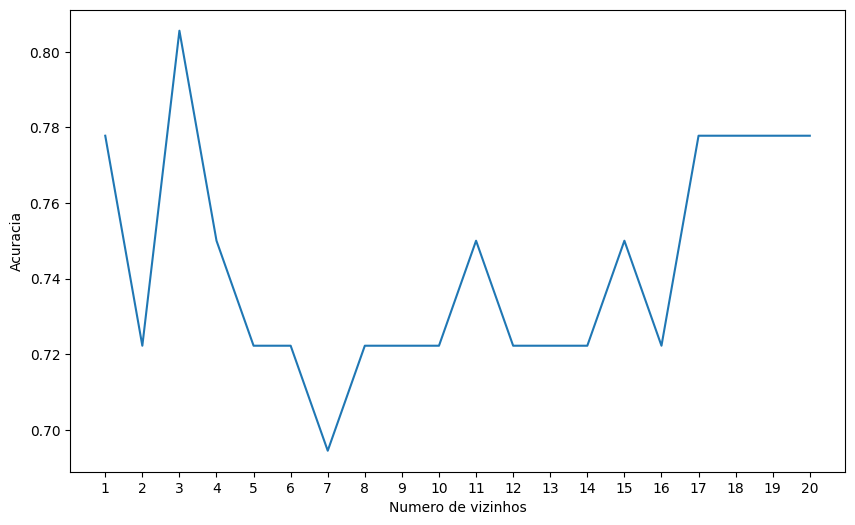

In [32]:
acuracies_df1 = pd.DataFrame(data=acuracies1, columns=['Acuracia'])
acuracies_df1['Numero de vizinhos'] = range(1, 21)
print(acuracies_df1)

plt.figure(figsize=(10, 6))
plt.plot(acuracies_df1['Numero de vizinhos'], acuracies_df1['Acuracia'])
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
# coloca 20 ticks no eixo x
plt.xticks(range(1, 21))
plt.show()
plt.close()

In [12]:
new_acuracies0 = dict()
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    new_acuracies0[produto] = []
    for vizinhos in (1,3,7,20):
        chutes = knn(X_train, y_train, X_test, vizinhos, Metrica(produto))
        new_acuracies0[produto].append(evaluate(y_test, chutes))

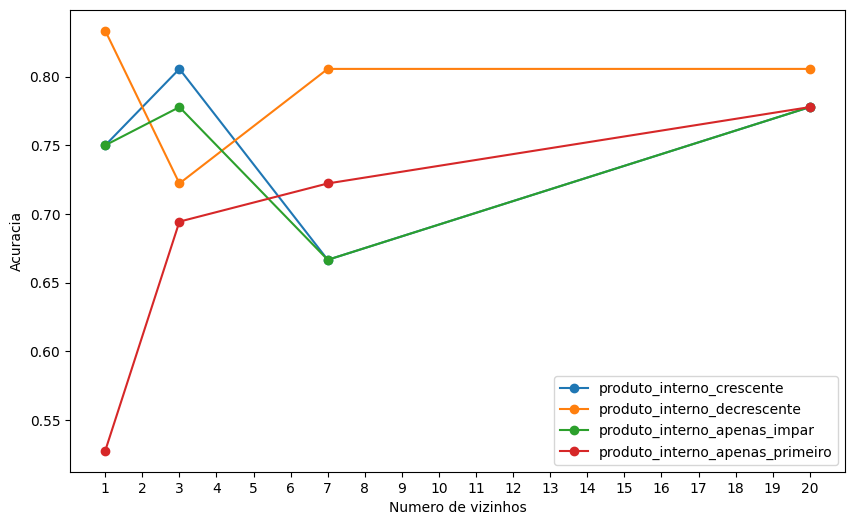

In [33]:
# plota as diversas metricas no mesmo grafico
plt.figure(figsize=(10, 6))
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    plt.plot((1,3,7,20), new_acuracies0[produto], label = produto.__name__, marker = "o")
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
plt.xticks(range(1, 21))
plt.legend()
plt.show()
plt.close()

# PCA e SVD

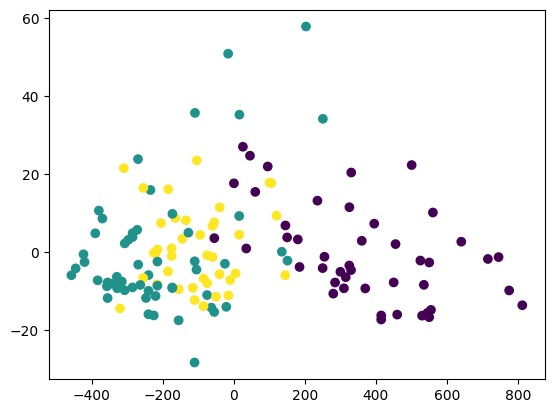

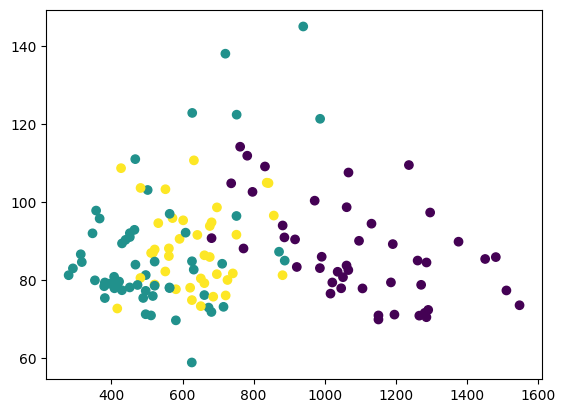

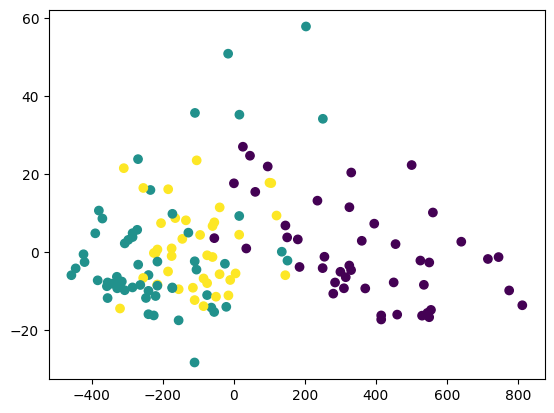

In [25]:
from jax.scipy.linalg import svd

def pca_sem_svd(data, num_components):
    # Calcula a matriz de covariância
    cov_matrix = jnp.cov(data, rowvar=False)
    # Calcula os autovalores e autovetores
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)
    # Ordena os autovetores de acordo com os autovalores
    idx = jnp.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Seleciona os num_components autovetores
    eigenvectors = eigenvectors[:, :num_components]
    # Transforma os dados originais
    return jnp.dot(data, eigenvectors)



def pca(data, num_components):
    # Centralizar os dados
    data_centered = data - jnp.mean(data, axis=0)

    # Calcular a matriz de covariância
    cov_matrix = jnp.dot(data_centered.T, data_centered) / (data_centered.shape[0] - 1)

    # Calcular a SVD da matriz de covariância
    U, S, VT = jnp.linalg.svd(cov_matrix)

    # Selecionar os primeiros componentes principais
    principal_components = VT[:num_components]


    # Projetar os dados nos componentes principais
    novo_dado = jnp.dot(data_centered, principal_components.T)

    return novo_dado

    


pca_vec = pca(X_train, 2)


plt.scatter(pca_vec[:, 0], pca_vec[:, 1], c=y_train_original)
plt.show()

pca_vec_sem_svd = pca_sem_svd(X_train, 2)

plt.scatter(pca_vec_sem_svd[:, 0], pca_vec_sem_svd[:, 1], c=y_train_original)
plt.show()

from sklearn.decomposition import PCA

pca_calculer = PCA(n_components=2)
pca_calculer.fit(X_train_original)
X_train_pca = pca_calculer.transform(X_train_original)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_original)
plt.show()
plt.close()



In [15]:
def base_ortonormal(matrix):
    # Calcular a SVD
    U, sigma, VT = svd(matrix)
    return VT

ortNor = base_ortonormal(X_train)

produto = jnp.dot(ortNor, ortNor.T)

if jnp.allclose(produto, jnp.eye(produto.shape[1]), atol=1e-6):
    # se a norma é 1
    if jnp.allclose(jnp.linalg.norm(produto, axis=0), 1):
        print("A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I")
    else:
        print("A matriz é apenas ortogonal, pois o módulo de suas colunas não é 1, mas A^T*A = I")
else:
    print("A matriz não é ortonormal nem ortogonal, pois A^T*A != I")

# se o det é 0
if jnp.abs(jnp.linalg.det(ortNor)) < 1e-6:
    print("A matriz é linearmente dependente, portanto não é uma base")
else:
    print("A matriz é uma base, pois é linearmente independente")

print("A base tem shape ", ortNor.shape, " e a matriz original tem shape ", X_train.shape)

A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I
A matriz é uma base, pois é linearmente independente
A base tem shape  (13, 13)  e a matriz original tem shape  (142, 13)


In [16]:
def obter_matriz_projecao(base):
    return jnp.dot(base, base.T)

def verificar_matriz_projecao(matriz_projecao):
    if jnp.allclose(matriz_projecao, matriz_projecao @ matriz_projecao, atol=1e-6):
        print("A matriz pode ser uma matriz de projeção, pois P^2 = P")
    else:
        print("A matriz não pode ser uma matriz de projeção, pois P^2 != P")
        return False
    if jnp.allclose(matriz_projecao, matriz_projecao.T, atol=1e-6):
        print("A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica")
        return True
    return False

matriz_projecao = obter_matriz_projecao(ortNor)
_ = verificar_matriz_projecao(matriz_projecao)

A matriz pode ser uma matriz de projeção, pois P^2 = P
A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica


# KNN com PCA

(178, 13)
(142, 2) (36, 2)


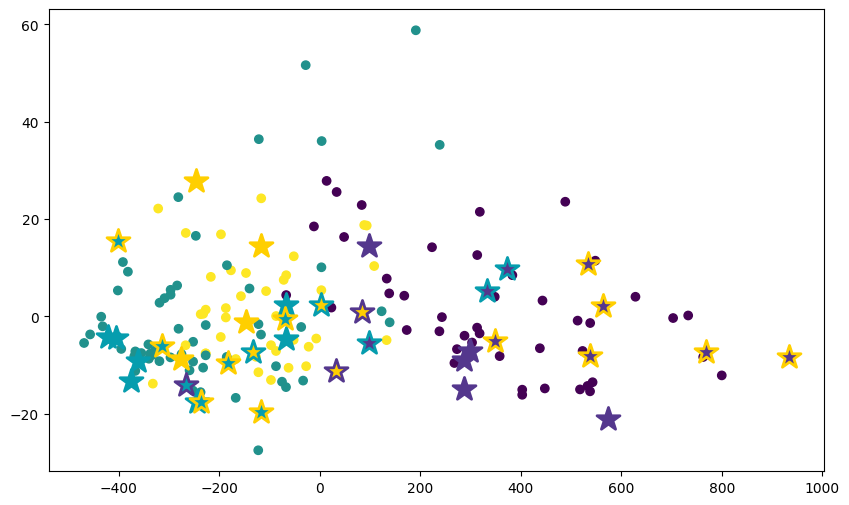

In [17]:
concatenado = jnp.concatenate((X_train, X_test), axis=0)
print(concatenado.shape)

# calcula o pca
pca_vec_conc = pca(concatenado, 2)

pca_train, pca_test = pca_vec_conc[:X_train.shape[0]], pca_vec_conc[X_train.shape[0]:]
print(pca_train.shape, pca_test.shape)

"""
cores = {0:'#069DAE', 1: '#FFCF00', 2:'#54378D'}
# deixa o plot maior
plt.figure(figsize=(10, 7))
#plota pca_train com bolinhas e suas classes
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train_original)
# plota pca_test com * e suas classes, alem de borda e tamanho 10
plt.sca
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y_test_original, marker='*', edgecolors="black", linewidth=1, s=300)
plt.show()
# printa as cores usadas
"""


def plot(x_train, y_train, x_test, y_test, chutes):
    cores = {1.0:'#069DAE', 2.0: '#FFCF00', 0.0:'#54378D'}
    # Criar o gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
    for c in np.unique(y_test):
        for ch in np.unique(chutes):
            mask = jnp.array((y_test == c) & (chutes == ch))
            # if jnp.sum(mask) == 0:
            #     continue
            plt.scatter(x_test[mask,0], x_test[mask,1], 
                        color=cores[c], 
                        edgecolor=cores[ch], 
                        linewidth=2,  
                        alpha=1.0, marker='*', s=300)

    plt.show()
    plt.close()

chutes = np.random.randint(0, 3, y_test_original.shape[0]).astype(float)
plot(pca_train, y_train_original, pca_test, y_test_original, chutes)

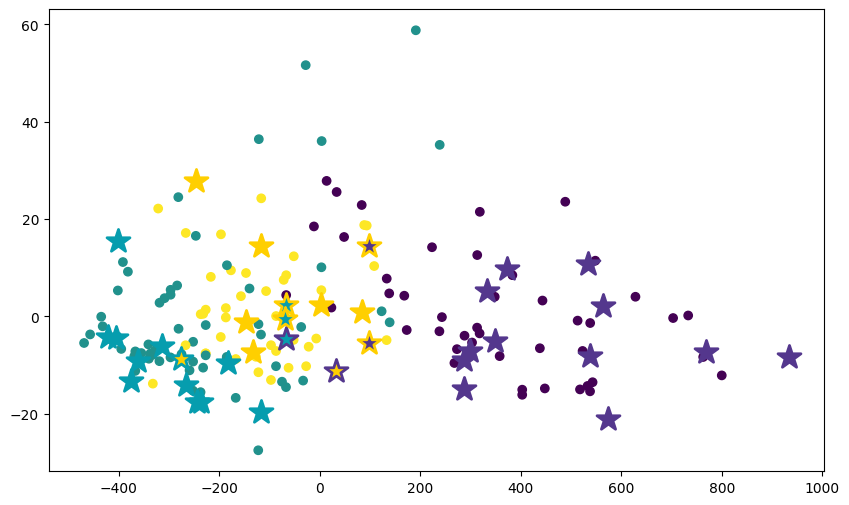

acuracia do knn proprio 0.8055555555555556


In [18]:
chutes = knn(X_train, y_train, X_test, 3, euclidean)
plot(pca_train, y_train_original, pca_test, y_test_original, chutes)
print("acuracia do knn proprio",evaluate(y_test, chutes))

In [19]:
acuracies = []
for i in range(1, 21):
    chutes = knn(X_train, y_train, X_test, i, euclidean)
    acuracies.append(evaluate(y_test, chutes))


    Acuracia  Numero de vizinhos
0   0.777778                   1
1   0.722222                   2
2   0.805556                   3
3   0.750000                   4
4   0.722222                   5
5   0.722222                   6
6   0.694444                   7
7   0.722222                   8
8   0.722222                   9
9   0.722222                  10
10  0.750000                  11
11  0.722222                  12
12  0.722222                  13
13  0.722222                  14
14  0.750000                  15
15  0.722222                  16
16  0.777778                  17
17  0.777778                  18
18  0.777778                  19
19  0.777778                  20


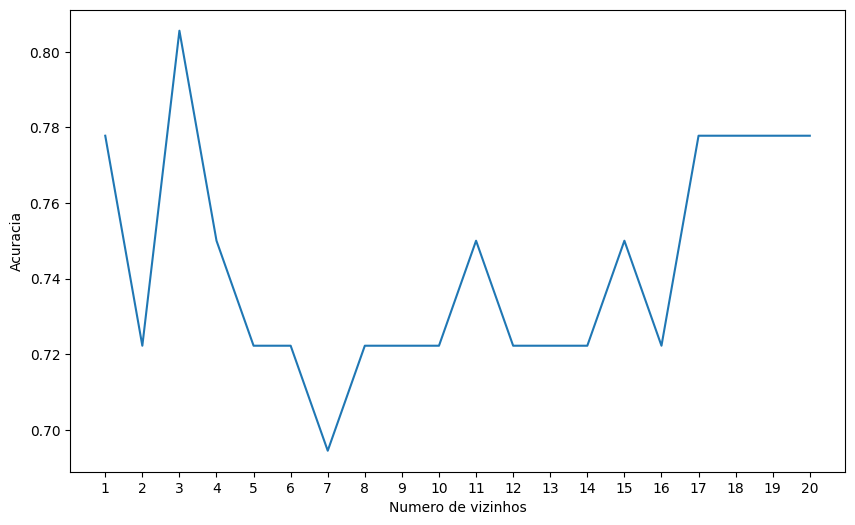

In [20]:
acuracies_df = pd.DataFrame(data=acuracies, columns=['Acuracia'])
acuracies_df['Numero de vizinhos'] = range(1, 21)
print(acuracies_df)

plt.figure(figsize=(10, 6))
plt.plot(acuracies_df['Numero de vizinhos'], acuracies_df['Acuracia'])
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
# coloca 20 ticks no eixo x
plt.xticks(range(1, 21))
plt.show()
plt.close()

In [21]:
new_acuracies = dict()
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    new_acuracies[produto] = []
    for vizinhos in (1,3,7,20):
        chutes = knn(X_train, y_train, X_test, vizinhos, Metrica(produto))
        new_acuracies[produto].append(evaluate(y_test, chutes))

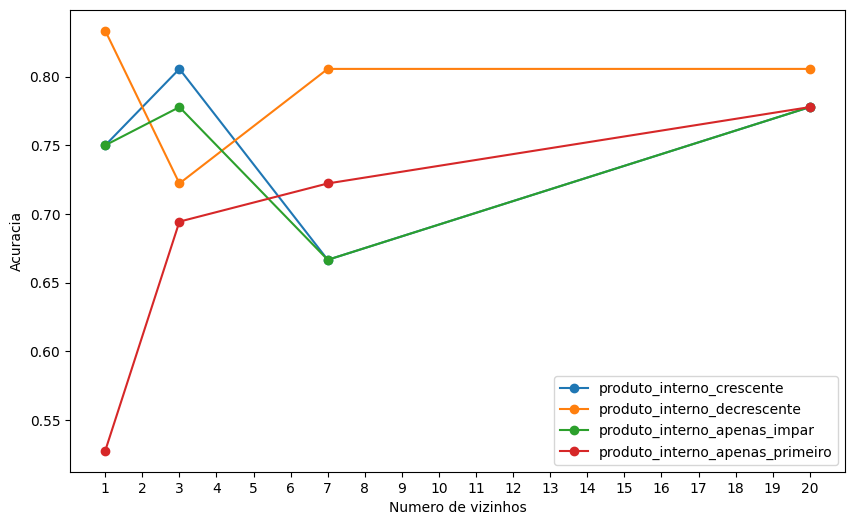

In [22]:
# plota as diversas metricas no mesmo grafico
plt.figure(figsize=(10, 6))
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    plt.plot((1,3,7,20), new_acuracies[produto], label = produto.__name__, marker = "o")
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
plt.xticks(range(1, 21))
plt.legend()
plt.show()
plt.close()

In [23]:
#mostrar tabela com acuracies_df e acuracies_df1
tabela_composta = pd.concat([acuracies_df, acuracies_df1], axis=1)
# 
# numero de vizinhos é o mesmo, então podemos remover uma das colunas
tabela_composta = tabela_composta.drop(columns=['Numero de vizinhos'])
print(tabela_composta)

    Acuracia  Acuracia
0   0.777778  0.777778
1   0.722222  0.722222
2   0.805556  0.805556
3   0.750000  0.750000
4   0.722222  0.722222
5   0.722222  0.722222
6   0.694444  0.694444
7   0.722222  0.722222
8   0.722222  0.722222
9   0.722222  0.722222
10  0.750000  0.750000
11  0.722222  0.722222
12  0.722222  0.722222
13  0.722222  0.722222
14  0.750000  0.750000
15  0.722222  0.722222
16  0.777778  0.777778
17  0.777778  0.777778
18  0.777778  0.777778
19  0.777778  0.777778
